## Решение

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import pandas as pd
from tqdm.notebook import tqdm

from IPython.display import clear_output

In [ ]:
import os
import pickle
from typing import Any, Callable, Optional, Tuple
from PIL import Image

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor, Compose
from torchvision.datasets.vision import VisionDataset

In [ ]:
dataset_root = "/content/drive/MyDrive/Project/"

Код для загрузки измененного датасета CIFAR10. Аргументы инициализации:

- `root` — строка, путь до директории с файлами датасета
- `train` — флаг, загружать часть для обучения или теста
- `transform` — преобразования изображения
- `target_transform` — преобразования класса изображения

In [ ]:
class Attractions(VisionDataset):

    def __init__(self,
                 root: str,
                 train: bool = True,
                 transform: Optional[Callable] = None,
                 target_transform: Optional[Callable] = None,
                 ) -> None:

        super().__init__(root, transform=transform, target_transform=target_transform)
        df = pd.read_csv(self.root + 'labels.csv')
        self.data = np.array(df['id'])
        self.data = np.array(df['id'])
        self.targets = np.array(df['label'])

    def get_n_classes(self):
      return len(np.unique(self.targets))

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        img = Image.open(self.root + 'resize32_data/' + self.data[index])
        target = self.targets[index]
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target

    def __len__(self) -> int:
        return len(self.data)
        
    def extra_repr(self) -> str:
        split = "Train" if self.train is True else "Test"
        return f"Split: {split}"

### Загрузка датасета

In [ ]:
import torchvision.transforms as transforms

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transf = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(10),
                ToTensor(),
                transforms.Normalize(mean, std)
                ])

data = Attractions(
    root=dataset_root,
    train=True,
    transform=transf
)

In [ ]:
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size

train_data, val_data = torch.utils.data.random_split(
    data, 
    [train_size, test_size], 
    generator=torch.Generator().manual_seed(42),
)

Инициализируем data loader-ы.

In [ ]:
batch_size = 128
train_dataloader = DataLoader(train_data, batch_size=batch_size)
val_dataloader = DataLoader(val_data, batch_size=batch_size)

In [ ]:
for X, y in train_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([128, 3, 32, 32])
Shape of y:  torch.Size([128]) torch.int64


### Модель классификации

Определяем, на каком устройстве будем обучать модель.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


Задаем архитектуру модели классификации. <br>
Тут большой простор для разных экспериментов. <br>

In [ ]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3*32*32, data.get_n_classes()),
)

Отправляем модель на выбранное устройство.

In [ ]:
model = model.to(device)
print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=3072, out_features=7, bias=True)
)


### Обучение

Задаем функцию потерь (цель оптимизации) и оптимизатор.

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

Код для визуализации процесса обучения.

Каждые `interval` шагов оптимизации и в конце эпох мы записываем значения функции потерь и метрик в лог. <br>
Затем вызовом функции `show_progress` обновляем график обучения. <br>

In [ ]:
# Training logs
interval = 100*20
fig = None
train_ts, train_loss = [], []
val_ts, val_loss, val_acc = [], [], []

In [ ]:
def show_progress(t):
    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(20, 5))
    fig.suptitle(f'Epoch {t:3.3f}', fontsize=16)
    ax1.set_title('loss')
    ax1.set_xlabel('time (epochs)')
    ax1.set_ylabel('loss')
    ax1.plot(train_ts, train_loss, c='darkblue', lw=3)
    ax1.plot(val_ts, val_loss, c='green', marker='o', lw=5)
    ax2.set_title('accuracy')
    ax2.set_xlabel('time (epochs)')
    ax2.plot(val_ts, val_acc, c='green', marker='o', lw=5)
    plt.show()

In [ ]:
def train(epoch, dataloader, model, loss_fn, optimizer):
    model.train()
    num_batches = len(dataloader)
    for batch, (X, y) in enumerate(dataloader):
        # Send data to training device
        X, y = X.to(device), y.to(device)
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Progress output
        if batch % interval == 0:
            t = epoch + (batch + 1)/num_batches
            train_ts.append(t)
            train_loss.append(loss.item())
            show_progress(t)

In [ ]:
def test(epoch, dataloader, model, loss_fn):
    model.eval()
    num_batches = len(dataloader)
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    val_ts.append(epoch+1)
    val_loss.append(test_loss)
    val_acc.append(correct)
    show_progress(epoch+1)

# Решение

А еще запихаем всякое в функции

In [ ]:
def go_model(mm, epochs):
  device = "cuda" if torch.cuda.is_available() else "cpu"
  print("Using {} device".format(device))
  mm = mm.to(device)
  print(mm)
  fig = None
  train_ts, train_loss = [], []
  val_ts, val_loss, val_acc, tr_acc, tr_loss, tr_ts = [], [], [], [], [], []
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(mm.parameters(), lr=1e-3)
  def show_progress(t):
    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(20, 5))
    fig.suptitle(f'Epoch {t:3.3f}', fontsize=16)
    ax1.set_title('loss')
    ax1.set_xlabel('time (epochs)')
    ax1.set_ylabel('loss')
    ax1.plot(train_ts, train_loss, c='darkblue', lw=3)
    ax1.plot(val_ts, val_loss, c='green', marker='o', lw=5)
    ax2.set_title('accuracy')
    ax2.set_xlabel('time (epochs)')
    ax2.plot(val_ts, val_acc, c='green', marker='o', lw=5)
    ax2.plot(tr_ts, tr_acc, c='blue', marker='o', lw=5)
    plt.show()
  def train(epoch, dataloader, model, loss_fn, optimizer):
    model.train()
    num_batches = len(dataloader)
    for batch, (X, y) in enumerate(dataloader):
        # Send data to training device
        X, y = X.to(device), y.to(device)
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Progress output
        if batch % interval == 0:
            t = epoch + (batch + 1)/num_batches
            train_ts.append(t)
            train_loss.append(loss.item())
            show_progress(t)
  def test(epoch, dataloader, tr_dataloader, model, loss_fn):
    model.eval()
    num_batches = len(dataloader)
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    val_ts.append(epoch+1)
    val_loss.append(test_loss)
    val_acc.append(correct)

    model.eval()
    num_batches = len(tr_dataloader)
    size = len(tr_dataloader.dataset)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in tr_dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    tr_ts.append(epoch+1)
    tr_loss.append(test_loss)
    tr_acc.append(correct)

    show_progress(epoch+1)
  for t in trange(epochs):
      train(t, train_dataloader, mm, loss_fn, optimizer)
      test(t, val_dataloader, train_dataloader, mm, loss_fn)

def write_solution(filename, labels):
    with open(filename, 'w') as solution:
        print('Id,Category', file=solution)
        for i, label in enumerate(labels):
            print(f'{i},{label}', file=solution)
            

In [ ]:
def init_weights(m):
  print(m)
  if type(m) == nn.Linear:
    nn.init.xavier_uniform_(m.weight)
  else:
    return
  print(m.weight)

Итак. Поскольку в прошлом задании все сработало неплохо, я решил и тут делать голосование. Но тут вот что-то не получилось особо хорошо :)

Основные мысли следующие: добавить несколько сверточных слоев, а потом сделать чуть больше чем 3 слоя нейронов. К таким выводам я пришел под конец, но вот получилась незадача - не успел.

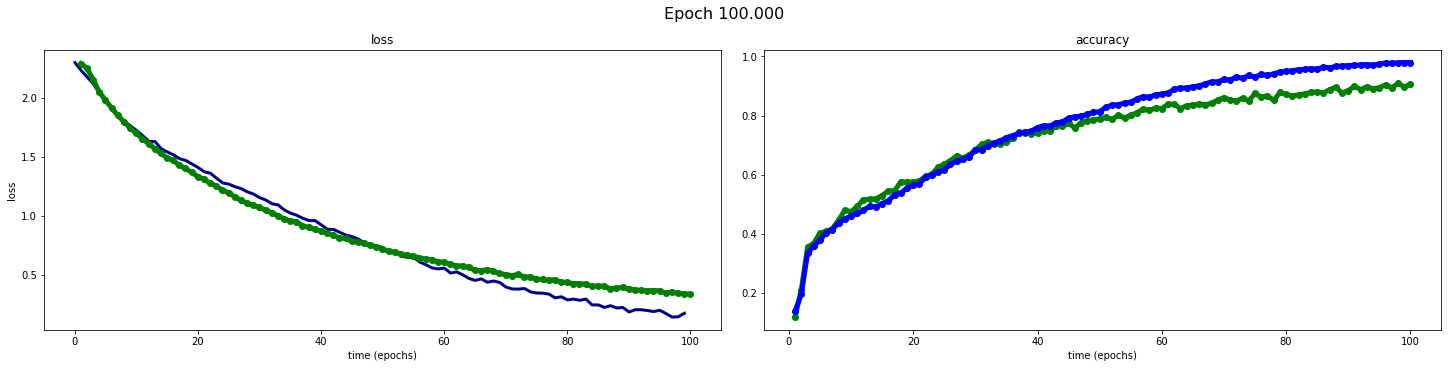

100%|██████████| 100/100 [16:25<00:00,  9.86s/it]


In [ ]:
model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.BatchNorm2d(64),

    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.BatchNorm2d(256),

    nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.BatchNorm2d(512),
    
    nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(1024, 2048, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.BatchNorm2d(2048),

    nn.Flatten(), 
    nn.Linear(8192, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 10))

#model.apply(init_weights)
go_model(model, 100)

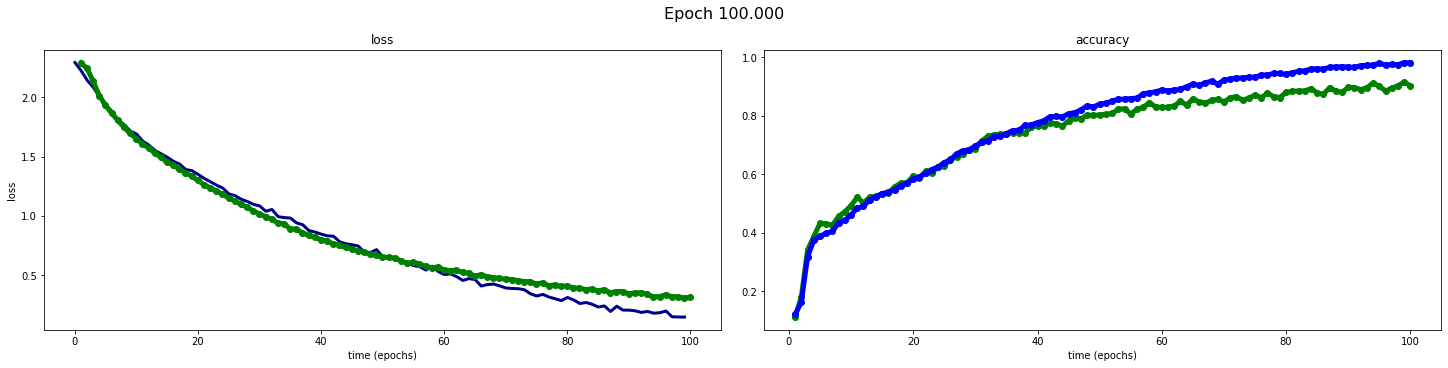

100%|██████████| 100/100 [16:02<00:00,  9.63s/it]


In [ ]:
model_2 = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.BatchNorm2d(64),

    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.BatchNorm2d(256),

    nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.BatchNorm2d(512),
    
    nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(1024, 2048, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.BatchNorm2d(2048),

    nn.Flatten(), 
    nn.Linear(8192, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 10))

model.apply(init_weights)
go_model(model_2, 100)

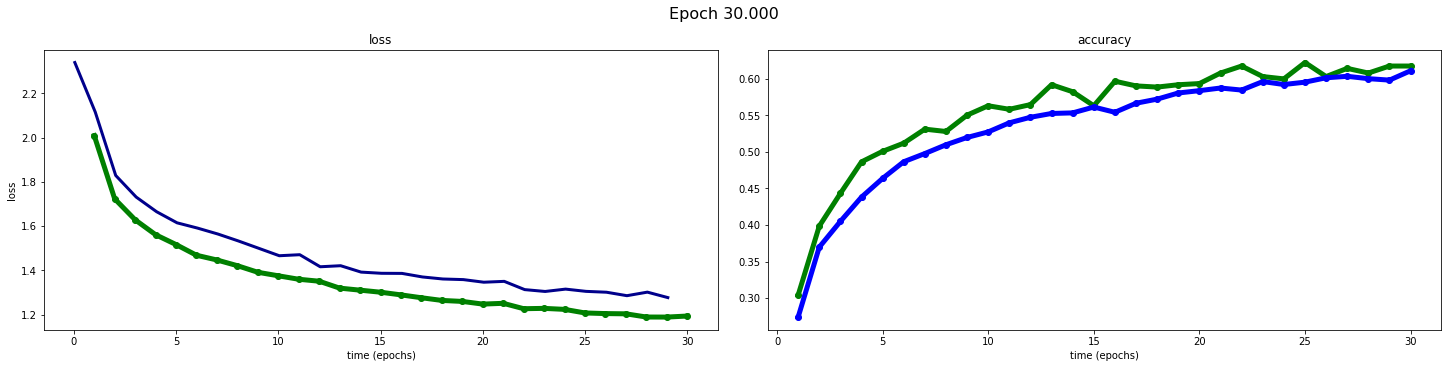

100%|██████████| 30/30 [04:23<00:00,  8.78s/it]


In [ ]:
model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.ReLU(),

    nn.Flatten(), 
    nn.Linear(32768, 10),
    nn.ReLU())

#model.apply(init_weights)
go_model(model, 30)

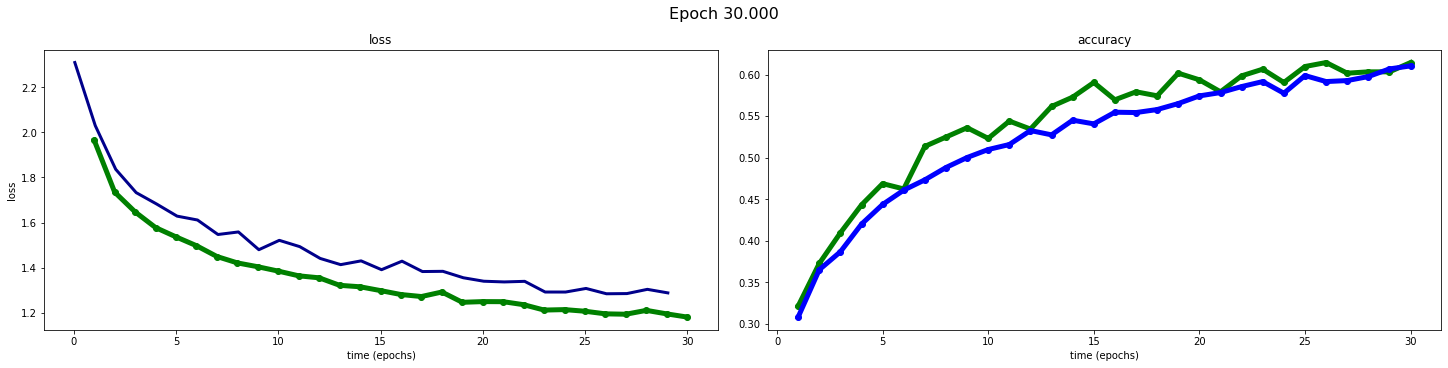

100%|██████████| 30/30 [04:34<00:00,  9.13s/it]


In [ ]:
model_2 = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.ReLU(),

    nn.Flatten(), 
    nn.Linear(32768, 10),
    nn.ReLU())

model_2.apply(init_weights)
go_model(model_2, 30)

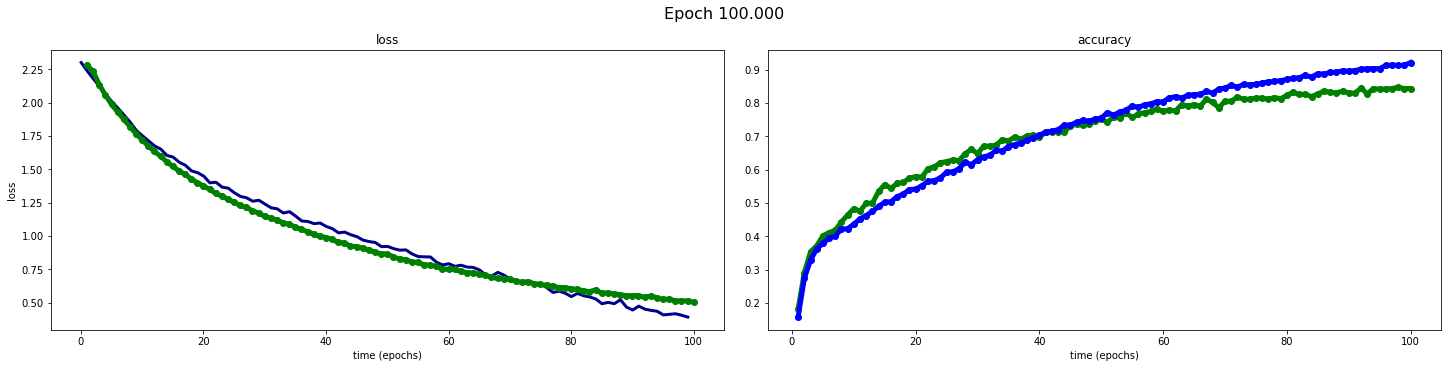

100%|██████████| 100/100 [16:03<00:00,  9.64s/it]


In [ ]:
model_3 = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.BatchNorm2d(64),

    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.BatchNorm2d(256),

    nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.BatchNorm2d(1024),

    nn.Flatten(), 
    nn.Linear(16384, 2048),
    nn.ReLU(),
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Linear(512, 10))

#model_3.apply(init_weights)
go_model(model_3, 100)

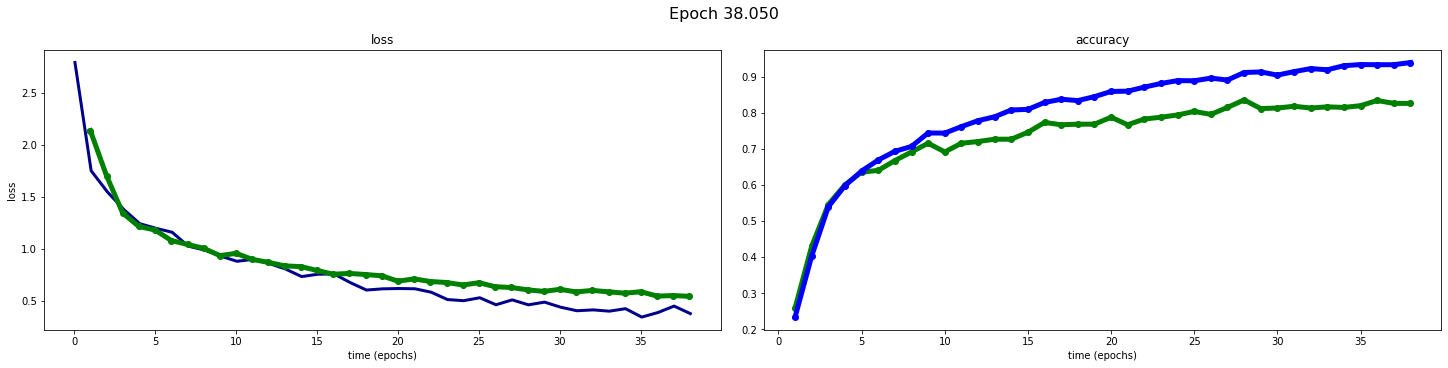

 38%|███▊      | 38/100 [06:08<10:01,  9.70s/it]


KeyboardInterrupt: ignored

In [ ]:
model_4 = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.BatchNorm2d(64),

    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.BatchNorm2d(256),

    nn.Flatten(), 
    nn.Linear(16384, 2048),
    nn.ReLU(),
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Linear(512, 10))

model_4.apply(init_weights)
go_model(model_4, 100)

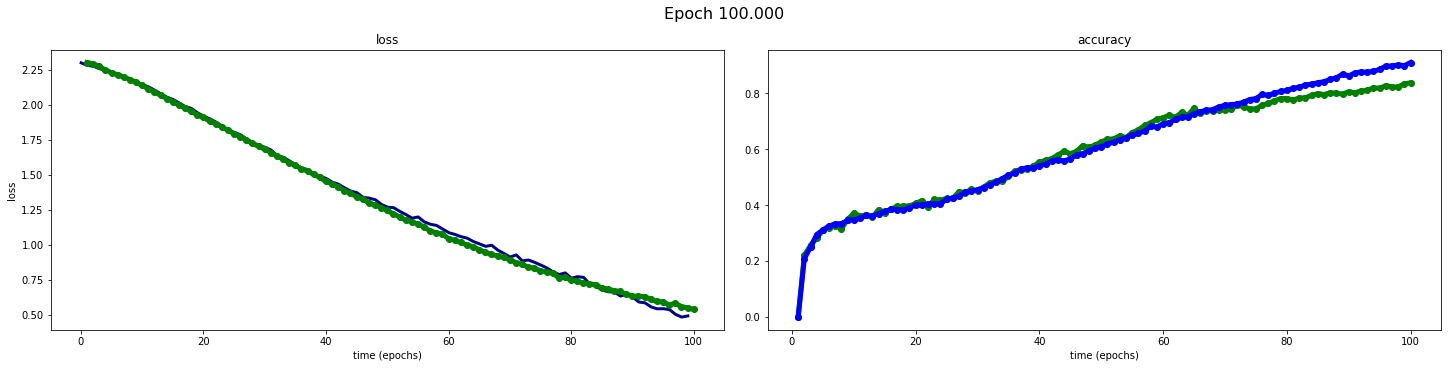

100%|██████████| 100/100 [32:36<00:00, 19.57s/it]


In [ ]:
model_5 = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.BatchNorm2d(64),

    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.BatchNorm2d(256),

    nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.BatchNorm2d(512),
    
    nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(1024, 2048, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.BatchNorm2d(2048),

    nn.Conv2d(2048, 4096, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(4096, 4096, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.BatchNorm2d(4096),

    nn.Flatten(), 
    nn.Linear(4096, 2048),
    nn.ReLU(),
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 10))

#model.apply(init_weights)
go_model(model_5, 100)

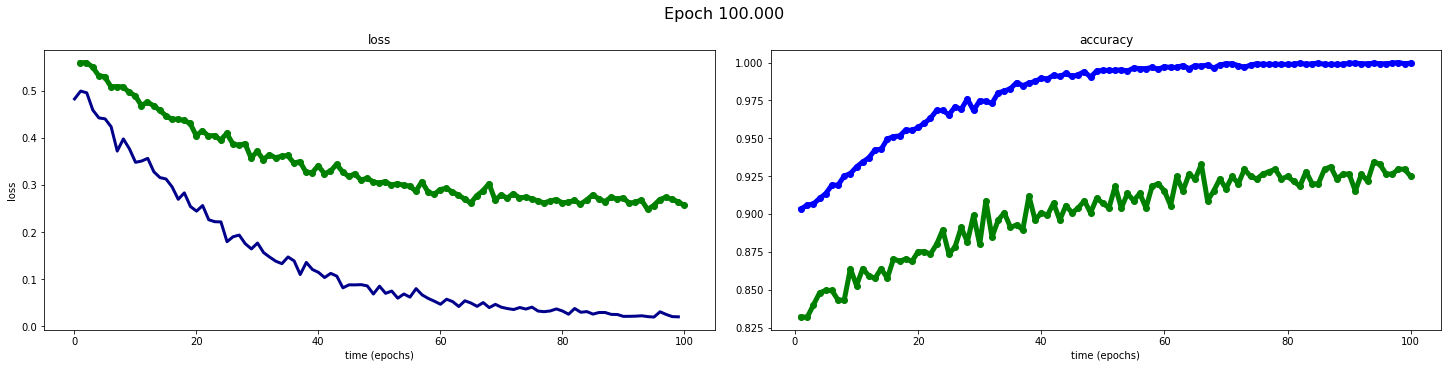

100%|██████████| 100/100 [25:18<00:00, 15.19s/it]


In [ ]:
go_model(model_5, 100)

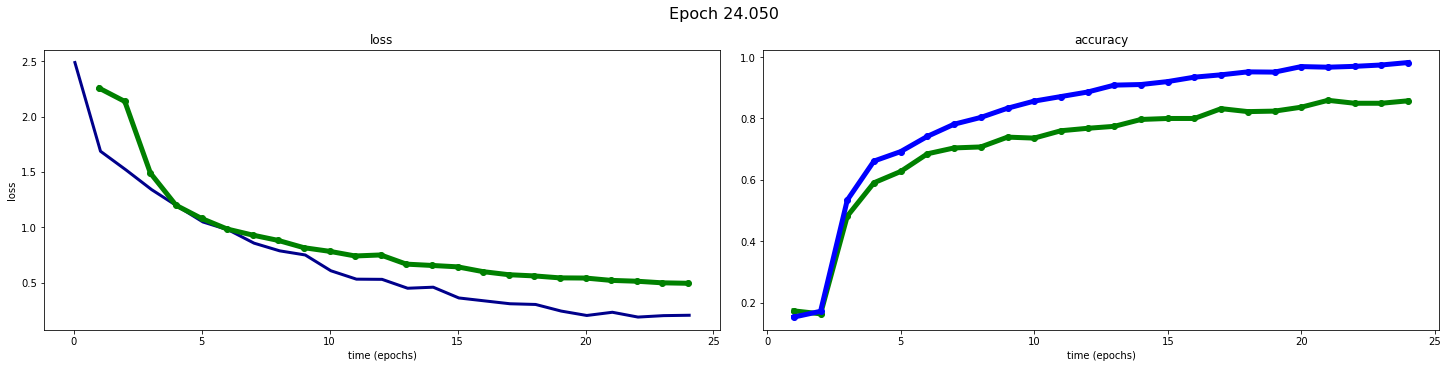

 12%|█▏        | 24/200 [03:59<29:17,  9.99s/it]


KeyboardInterrupt: ignored

In [ ]:
model_6 = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.BatchNorm2d(64),

    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.BatchNorm2d(128),

    nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.BatchNorm2d(256),

    nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.BatchNorm2d(512),

    nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(1024, 2048, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.BatchNorm2d(2048),

    nn.Flatten(), 
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 10))

model_6.apply(init_weights)
go_model(model_6, 200)